The code presented here is tuned for local testing of PySpark and loading data from local storage, not from Hive managed tables

## Initialise PySpark

In [1]:
!export SPARK_HOME=/Users/fluffy/Downloads/spark-3.0.1-bin-hadoop2.7

In [2]:
import findspark
findspark.init('/Users/fluffy/Downloads/spark-3.0.1-bin-hadoop2.7')

In [109]:
import datetime
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
datasets_path = 'data/cumulative'

In [19]:
#!export PYSPARK_DRIVER_PYTHON=~/anaconda3/envs/BDT/bin/python
#!export PYSPARK_PYTHON=~/anaconda3/envs/BDT/bin/python

In [5]:
from pyspark import SparkContext
sc = SparkContext("local", "First App")

In [6]:
import pyspark
from pyspark.sql import SparkSession

import pyspark.sql.functions as sf

from pyspark.sql import Window
from pyspark.sql import functions as F

from pyspark.sql.functions import udf

from pyspark.sql.functions import mean as _mean, stddev_pop as _stddev_pop, col

In [7]:
# Create a spark session
spark = SparkSession.builder.getOrCreate()

In [522]:
output_data_folder = 'output_data'

if not os.path.isdir(output_data_folder):
    os.mkdir(output_data_folder)
    
output_data_plots_path = os.path.join(output_data_folder, 'plots')
if not os.path.isdir(output_data_plots_path):
    os.mkdir(output_data_plots_path)

## Reading some dataset extract to model cumulative reports in Hadoop

The code that you see below in this section is responsible for local PySpark data modelling and quieries testing. I have created a local Spark session, split the big dataset into daily reports to simulate the task given to us. Each daily report is stored as an independent .csv file which is identified by the date.

With the help of the code below I read just a fraction of these files so that I can produce daily reports for each timespan I wish. The whole code is already prepared to work on Hadoop since the only difference is in the way how the final PySpart data frame is obtained.

For the local environment, I use local .csv files and Pandas data frames, which are then translated into corresponding PySpark dataframes.

For the "production" environment, we assume that the daily logs are being automatically uploaded by a CRON job which moves each daily report as a .csv file into a designated folder on HDFS, then calls Hive to insert these data from the external daily sales logs table (which is binded to this HDFS directory where all .csv files are being moved to) into a managed sales_log table, which containes all sales from the whole time span. I call this table cumulative since it shows all the data available till some particular day. 
This data is been quiried by HQL and the resulting table is being stored in PySpark data frame. The following steps are identical as in the "local" set up

In [485]:
days_to_take = 365 * 2

In [486]:
import os
from pathlib import Path

paths = sorted(Path('data/daily_reports').iterdir(), key=os.path.getmtime)


In [487]:
df_list = []

for path in paths[1:days_to_take + 1]:
    dataset_df = pd.read_csv(
        path,
        parse_dates=[0],
        date_parser=lambda col: pd.to_datetime(col, format="%d.%m.%Y")
    )
    
    df_list.append(dataset_df)

In [488]:
df = pd.concat(df_list)
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-01,0,18,5823,2500.0,1.0
1,2013-01-01,0,27,5573,849.0,1.0
2,2013-01-01,0,7,1006,399.0,1.0
3,2013-01-01,0,19,17707,899.0,1.0
4,2013-01-01,0,14,19548,149.0,1.0
...,...,...,...,...,...,...
8342,2014-12-31,23,6,15400,1689.0,1.0
8343,2014-12-31,23,28,9396,299.0,4.0
8344,2014-12-31,23,28,10382,699.0,1.0
8345,2014-12-31,23,6,16035,499.0,1.0


In [489]:
spark_df = spark.createDataFrame(df)
spark_df.count()

2323423

In [490]:
# Delete rows with negative sales
cum_sales_df_filtered = spark_df.filter(spark_df.item_cnt_day > 0)

## Reading 2 helper datasets with descriptions

#### These datasets are stored locally since they are not big at all and there is no need to distribute it

In [491]:
categories_data_path = 'data/item_categories.csv'
items_data_path = 'data/items.csv'

In [492]:
categories_df = pd.read_csv(categories_data_path)
items_df = pd.read_csv(items_data_path)

In [493]:
categories_df = spark.createDataFrame(categories_df)
items_df = spark.createDataFrame(items_df)

In [494]:
categories_df.show()

+--------------------+----------------+
|  item_category_name|item_category_id|
+--------------------+----------------+
|PC - Гарнитуры/На...|               0|
|    Аксессуары - PS2|               1|
|    Аксессуары - PS3|               2|
|    Аксессуары - PS4|               3|
|    Аксессуары - PSP|               4|
| Аксессуары - PSVita|               5|
|Аксессуары - XBOX...|               6|
|Аксессуары - XBOX...|               7|
|      Билеты (Цифра)|               8|
|     Доставка товара|               9|
|Игровые консоли -...|              10|
|Игровые консоли -...|              11|
|Игровые консоли -...|              12|
|Игровые консоли -...|              13|
|Игровые консоли -...|              14|
|Игровые консоли -...|              15|
|Игровые консоли -...|              16|
|Игровые консоли -...|              17|
|          Игры - PS2|              18|
|          Игры - PS3|              19|
+--------------------+----------------+
only showing top 20 rows



# ABC/XYZ analysis

The most important part of the whole assignment is to classify our goods we sell in all our shops along 2 axes:

    - 1st axis: ABC analysis.
        We aim to find those goods which contribute to our sales most whilst being a small fraction of the whole assortiment. This is known to be A category. Then, we find less important, but still essential group B and "throw" the rest of goods into category C. 
        Unfortunately, these categories are vaguely defined and since ABC analysis originates from materials management industry, its meaning in sales is often differently interpreted.
        
        As for this assignment, I fix the definition of ABC categories in this way. All the goods are assigned exactly one category basing on the following schema:
        - We find the number of products sold across different shops and sum this value to produce overall number.
        - We sort these products according to the number of sold items in a descending order (so that those products which are sold more are pushed to the upper part of the dataframe)
        - We calculate cumulative number of sold items with the help of sliding windows from up till down of the dataset.
        - Then, for each row (the number of rows is the same as the number of unique products sold in our shop) we transform this cumulative number of sold items into percentage.
        - The ABC classification algorithm can take place: A category is assigned to those products having less than 60% of cumulative percentage, B category is assigned to next products under 80% of cumulative percentace, the rest is been assigned the last C category.
            In the realm of ABC analysis, we expect that the distribution of products in each category will be something like: A - 20% of all products, B - 30% of all products, C - 50% of all products.
            
            
     - 2nd axis: XYZ analysis.
     
         The aim of XYZ analysis is to assess the stability of the request for each product. Each uniqie product is assigned a category X, Y or Z (that's the reason for the name of this analysis) depicting the "seasonality" of the sales. That's why it is important to select an appropriate time frame for measuring XYZ classes. 
         
         XYZ analysis is defined as assigning a category basing on test statistic known as a coefficient of variation (or relative standard deviation). It's a well-known way of measuring dispersion of a probability distribution or frequency distribution and hence is defined as the ratio of the standard deviation to the mean of the measured values. In our case the mean is been calculated as the average number of sold items of each product for each month. So, it there is data from 2 years of operating our eshop, we will have to calculate the mean from 24 numbers. Then, the standard deviation from the same numbers is been calculated and the final coefficient is been obtained. 
         
         Each category is assigned basing on the resulting coefficient of variation:
             - X is given to those products having values from 0% to 10% (stable requests, no seasonality)
             - Y is given to those products having values from 10% to 25% (some bigger deviations in sales, possible seasonality)
             - Z is given to the rest of the products (some extraordinary sales).
             
             
The result of this section is a 2D grid of products that have 2 categories assigned. It will profoundly help us in further analysis.
           

### ABC analysis

For each item on sale count the number of sold items across all the shops

In [495]:
cum_sales_df_summed = cum_sales_df_filtered.groupby('item_id').agg(sf.sum('item_cnt_day').alias('item_cnt_day'))

Sort them in descending order by the number of sold items

In [496]:
cum_sales_df_summed_sorted = cum_sales_df_summed.sort(cum_sales_df_summed.item_cnt_day.desc())

Calculate cumulative sum of sold items

In [497]:
cum_sales_df_cumsum = cum_sales_df_summed_sorted.withColumn('cumsum', 
    F.sum('item_cnt_day').over(Window.rowsBetween(Window.unboundedPreceding, Window.currentRow))
)

Take the grand total of the cumulative sum

In [498]:
cumsum_value = cum_sales_df_cumsum.select(cum_sales_df_cumsum['cumsum']).collect()[-1]
cumsum_value

Row(cumsum=2889491.0)

Transform the cumulative numbers of sales into the percentages of the grand total value

This is done in order to define A, B, C classes basing on 60%, 80% and 100% sales thresholds

In [499]:
round_func = udf(lambda val: round(val / cumsum_value['cumsum'], 3))

cum_sales_df_perc = cum_sales_df_cumsum.withColumn('percentage', round_func(cum_sales_df_cumsum.cumsum))

Classify each sold item into A, B, C categories

In [500]:
# Helper function
def abc_classify_func(perc_value):
    # If the cumulative percentage of total sold items is less then 0.6, then it's A category
    if perc_value <= 0.6:
        return 'A'
    # If this item is between 60% and 80% of sold items, then it belongs to B category
    elif perc_value <= 0.8:
        return 'B'
    # Otherwise, it's C
    else:
        return 'C'

# Make this function UDF - user defined function in accordance with Spark documentation
abc_classify = udf(abc_classify_func)

cum_sales_df_abc = cum_sales_df_perc.withColumn('ABC', abc_classify(cum_sales_df_perc.percentage))

In [501]:
cum_sales_df_abc.show()

+-------+------------+--------+----------+---+
|item_id|item_cnt_day|  cumsum|percentage|ABC|
+-------+------------+--------+----------+---+
|  20949|    149053.0|149053.0|     0.052|  A|
|   2808|     16252.0|165305.0|     0.057|  A|
|   3732|     15831.0|181136.0|     0.063|  A|
|   3734|     10851.0|191987.0|     0.066|  A|
|   5822|     10389.0|202376.0|      0.07|  A|
|   6675|      9319.0|211695.0|     0.073|  A|
|   1855|      9247.0|220942.0|     0.076|  A|
|  16787|      8912.0|229854.0|      0.08|  A|
|  17717|      8562.0|238416.0|     0.083|  A|
|   3331|      7716.0|246132.0|     0.085|  A|
|   7856|      7623.0|253755.0|     0.088|  A|
|   2814|      7097.0|260852.0|      0.09|  A|
|   2445|      7041.0|267893.0|     0.093|  A|
|   6738|      6871.0|274764.0|     0.095|  A|
|   1830|      6863.0|281627.0|     0.097|  A|
|   4181|      6425.0|288052.0|       0.1|  A|
|   4870|      6049.0|294101.0|     0.102|  A|
|   3183|      5913.0|300014.0|     0.104|  A|
|   6740|    

See how many different products have been sold for this timespan

In [502]:
unique_products_num = cum_sales_df_abc.count()
unique_products_num

19044

How many items have been sold for this timespan

In [503]:
cum_sales_df_abc.select('cumsum').collect()[-1]

Row(cumsum=2889491.0)

Show the percentage of A, B and C categories with respect to the whole dataset

In [504]:
A_df = cum_sales_df_abc.filter(cum_sales_df_abc['percentage'] <= 0.6)
B_df = cum_sales_df_abc.filter((cum_sales_df_abc['percentage'] <= 0.8) & (cum_sales_df_abc['percentage'] > 0.6))
C_df = cum_sales_df_abc.filter((cum_sales_df_abc['percentage'] <= 1.0) & (cum_sales_df_abc['percentage'] > 0.8))



print(f'The percentage of A products is {(A_df.count()/unique_products_num):.3%}')
print(f'The percentage of B products is {(B_df.count()/unique_products_num):.3%}')
print(f'The percentage of C products is {(C_df.count()/unique_products_num):.3%}')


The percentage of A products is 6.973%
The percentage of B products is 11.132%
The percentage of C products is 81.895%


### XYZ analysis

See if there are negative values

In [505]:
cum_sales_df_filtered.select('item_cnt_day').describe().show()

+-------+------------------+
|summary|      item_cnt_day|
+-------+------------------+
|  count|           2317702|
|   mean|1.2467051415583195|
| stddev|1.9579214469091533|
|    min|               1.0|
|    max|             512.0|
+-------+------------------+



In [506]:
cum_sales_df_filtered.columns

['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']

In [507]:
### Resolve column names differences
if 'date_block_num' in cum_sales_df_filtered.columns:
    cum_sales_df_filtered = cum_sales_df_filtered.withColumnRenamed('date_block_num', 'month_num')


In [508]:

monthly_sales_df = cum_sales_df_filtered.groupby('month_num', 'item_id').agg(sf.sum('item_cnt_day').alias('item_cnt_month'))

Calculate mean values and population standard deviation for calculating coefficients of variation

In [509]:
stats_df = monthly_sales_df.groupby('item_id').agg(
    _mean(col('item_cnt_month')).alias('mean'),
    _stddev_pop(col('item_cnt_month')).alias('std')
)


var_coeff_func = udf(lambda std_val, mean_val: round((std_val / mean_val), 3))

final_stats_df = stats_df.withColumn('var_coeff', var_coeff_func(stats_df.std,stats_df.mean))

Classify basing on the coefficients of variation values

In [510]:
def xyz_classify_func(perc_value):
    if perc_value <= 0.10:
        return 'X'
    elif perc_value <= 0.25:
        return 'Y'
    else:
        return 'Z'

xyz_classify = udf(xyz_classify_func)

xyz_classification_df = final_stats_df.withColumn('XYZ', xyz_classify(final_stats_df.var_coeff))

In [511]:
xyz_classification_df.sort(xyz_classification_df.var_coeff.desc()).show(), xyz_classification_df.count()

+-------+------------------+------------------+---------+---+
|item_id|              mean|               std|var_coeff|XYZ|
+-------+------------------+------------------+---------+---+
|  19232|11.857142857142858| 37.00615870788165|    3.121|  Z|
|  15043|  40.1764705882353|  123.528151254073|    3.075|  Z|
|   2278| 78.46153846153847|234.50393317502417|    2.989|  Z|
|   8057|            103.25|303.55837576980144|     2.94|  Z|
|  21372|33.285714285714285| 96.82735881436602|    2.909|  Z|
|   7068|              76.8|221.96634880089368|     2.89|  Z|
|   6739| 47.44444444444444| 136.2922604072351|    2.873|  Z|
|  10057|              17.0|47.836343813816754|    2.814|  Z|
|  14850|11.764705882352942| 32.87503864773341|    2.794|  Z|
|  21541|              23.0| 63.71215029519955|     2.77|  Z|
|  10451|10.521739130434783| 28.60658112973214|    2.719|  Z|
|  11240|36.611111111111114| 98.41416953585545|    2.688|  Z|
|  16450|            92.125| 243.8394814387804|    2.647|  Z|
|   7097

(None, 19044)

### ABC/XYZ - putting it all together

In [512]:
xyz_classification_df_extract = xyz_classification_df.select('item_id', 'XYZ')
cum_sales_df_abc_extract = cum_sales_df_abc.select('item_id', 'ABC')

Inspect column names of two dataframes so that we will be able to start joining them

In [513]:
cum_sales_df_abc.columns, xyz_classification_df_extract.columns

(['item_id', 'item_cnt_day', 'cumsum', 'percentage', 'ABC'],
 ['item_id', 'XYZ'])

Join both dataframes

In [514]:
abc_xyz_df = cum_sales_df_abc_extract.\
join(
    xyz_classification_df_extract,
    cum_sales_df_abc_extract.item_id == xyz_classification_df_extract.item_id,
    'inner'
).\
drop(xyz_classification_df_extract.item_id)

abc_xyz_df.count()

19044

In [515]:
abc_xyz_df.select('item_id','ABC', 'XYZ').show()

+-------+---+---+
|item_id|ABC|XYZ|
+-------+---+---+
|     26|  C|  X|
|     29|  C|  Z|
|    474|  C|  Z|
|    964|  C|  Z|
|   1677|  C|  Z|
|   1697|  C|  X|
|   1806|  C|  X|
|   1950|  C|  Z|
|   2040|  C|  Y|
|   2214|  C|  Z|
|   2250|  C|  X|
|   2453|  C|  X|
|   2509|  C|  Z|
|   2529|  C|  Z|
|   2927|  C|  Z|
|   3091|  C|  X|
|   3506|  C|  Z|
|   3764|  C|  Z|
|   4590|  C|  X|
|   4823|  C|  Z|
+-------+---+---+
only showing top 20 rows



Save the result

In [516]:
abc_xyz_df.coalesce(1).write.mode('overwrite').csv(f'{output_data_folder}/abc_xyz_dataframe.csv', header=True)


## Visualize ABC/XYZ classification

In [517]:
abc_xyz_counts = abc_xyz_df.groupby('ABC', 'XYZ').count()
abc_xyz_counts = abc_xyz_counts.sort(abc_xyz_counts.ABC.asc(), abc_xyz_counts.XYZ.asc())

This dataset is already pretty small containing only 9 rows, so we can proceed with a regular Pandas DataFrame class

In [518]:
abc_xyz_counts_pd = abc_xyz_counts.toPandas()
abc_xyz_counts_pd

,ABC,XYZ,count
0,A,X,9
1,A,Y,35
2,A,Z,1284
3,B,X,28
4,B,Y,46
5,B,Z,2046
6,C,X,4042
7,C,Y,188
8,C,Z,11366


For small extracts or small time spans we expect that there will be no some category (overall there are 9 different assignments of ABC and XYZ categories). In order to display ABC/XYZ, we need to fill in "blank spots".

In [519]:
# Add missing pairs

pairs = [
    ('A', 'X'),
    ('A', 'Y'),
    ('A', 'Z'),
    ('B', 'X'),
    ('B', 'Y'),
    ('B', 'Z'),
    ('C', 'X'),
    ('C', 'Y'),
    ('C', 'Z'),
]


add_list = []

for pair in pairs:
    if len(abc_xyz_counts_pd[(abc_xyz_counts_pd.ABC == pair[0]) & (abc_xyz_counts_pd.XYZ == pair[1])]) == 0:
        add_list.append([pair[0], pair[1], 0])

# add_list denotes those classes that are needed to be added to the the pandas df so that we have all 9 entries
add_list

[]

In case when we have some missing category, add them manually so that we are able to create a 3x3 matrix a visualise it

In [520]:
full_abc_xyz_counts = abc_xyz_counts_pd.append(pd.DataFrame(add_list, columns = abc_xyz_counts_pd.columns))
full_abc_xyz_counts = full_abc_xyz_counts.sort_values(['ABC', 'XYZ'], ascending=[True, True])
full_abc_xyz_counts

,ABC,XYZ,count
0,A,X,9
1,A,Y,35
2,A,Z,1284
3,B,X,28
4,B,Y,46
5,B,Z,2046
6,C,X,4042
7,C,Y,188
8,C,Z,11366


Use Matplotlib to arrange 3x3 categories into a 3x3 grid (matrix) with the number of products falling into each category

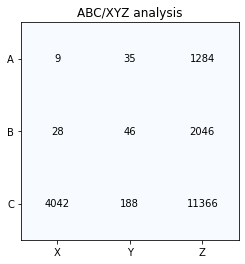

In [523]:
values_matrix = full_abc_xyz_counts['count'].to_numpy().reshape((3, 3))

fig, ax = plt.subplots()

ax.matshow(np.zeros(9).reshape((3, 3)), cmap=plt.cm.Blues)

for i in range(3):
    for j in range(3):
        c = values_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

        
plt.yticks([0, 1, 2], labels=['A', 'B', 'C'])
plt.xticks([0, 1, 2], labels=['X', 'Y', 'Z'])
ax.xaxis.set_ticks_position('bottom')

plt.title('ABC/XYZ analysis')
plt.savefig(f'{output_data_plots_path}/abc_xyz_grid.png')
plt.show()



As we can see from the matrix above we have 9 products from category A which represent the most vital part of the presented products in our business since A category says that this product falls into the bucket of goods being sold most of the time, and X category denoting strong stability of the need for these products. That's why it is crucial to know which products are these. 

Then, we see that most of our goods are classified with Z label saying that we have lots products being affected by some factors (social and economic, maybe cultural as well) causing the request for these products less stable and more volatile. We will examine it later.

We also have to take into consideration the goods from BX category, since they produce less number of sold items but they are believed to be stable enough, so that we can sell them all seasons and holidays regardless.

In [524]:
for pair in pairs:
    print(f'\n\nCategory {pair[0]:2}{pair[1]:2} representatives:\n')
    
    pair_df = abc_xyz_df.filter((abc_xyz_df.ABC == pair[0]) & (abc_xyz_df.XYZ == pair[1])).limit(10)
    
    pair_df_with_names = pair_df.join(items_df, pair_df.item_id == items_df.item_id).drop(items_df.item_id)
    products = pair_df_with_names.select('item_name').collect()
    
    for product in products:
        print(product.__getitem__('item_name'))
    



Category A X  representatives:

Assassin's Creed: Изгой [Xbox 360, русская версия]
Crew. Специальное издание [PC, русская версия]
Crew. Специальное издание [PS4, русская версия]
Diablo III: Reaper of Souls (дополнение) [PC, Jewel, русская версия]
Dragon Age: Инквизиция [PS4, русские субтитры]
Grand Theft Auto V [Xbox One, русские субтитры]
PINK FLOYD  The Endless River (фирм.)
ЛЮСИ
ЧЕРЕПАШКИ-НИНДЗЯ


Category A Y  representatives:

BOCELLI ANDREA  Vivere  The Best Of
Bestseller. Grand Theft Auto: San Andreas [PC, Jewel]
Call of Duty: Advanced Warfare [PS4, русская версия]
Kaspersky Internet Security Multi-Device Russian Edition. 2-Device 1 year Base Box
LittleBigPlanet 3 [PS4, русская версия]
Minecraft. Playstation 3 Edition [PS3, русская версия]
Ultimate Games. Hitman Absolution [PС, Jewel, русская версия]
Win Home Prem 7 Russian Russia Only DVD
World of Warcraft. Карта оплаты игрового времени (online) (рус.в.) (60 дней) (Jewel)
Мягкая игрушка Minecraft Baby Pig 7"


Category A Z  r

What can we say here? We see the clear trend that console games are being sold really solidly and in a stable fashion. Some games are less popular than others, but still we see lots of known representatives of game industry popular in the presented years. These years are also characterized as the rise of console gaming, which we see reflected in our data: PC games are less stable (judging by top 10 values of the list presented here, we will study this effect more thoroughly in next sections).

# Exploratory analysis

### Average product price

In [525]:
mean_prices_df = cum_sales_df_filtered.groupby('item_id').agg(sf.mean('item_price').alias('mean_price'))
mean_prices_df = mean_prices_df.join(items_df, mean_prices_df.item_id == items_df.item_id, 'inner')
mean_prices_df = mean_prices_df.sort(mean_prices_df.mean_price.desc())

top_10_df = mean_prices_df.take(10)

for row in top_10_df:
    mean_price = round(row['mean_price'], 2)
    print(row['item_name'], mean_price)


Radmin 3  - 522 лиц. 307980.0
Коллекционные шахматы (Властелин Колец) 50999.0
UserGate Proxy & Firewall 6.X до 100 сессий 42000.0
Лицензия 1С-Битрикс: Управление сайтом - Эксперт 40900.0
Photoshop 13 Windows Russian BOX 35132.86
CorelDRAW Graphics Suite X6 - Small Business Edition Russian BOX 34713.5
ESET NOD32 Smart Security Business Edition newsale for 20 user 29700.0
Project 2013 32-bit/x64 Russian CEE DVD 28990.0
1С:Бухгалтерия 8 ПРОФ на 5 польз. Поставка для розничного распространения. 28050.0
1С-Битрикс: Управление сайтом - Малый бизнес [PC, Цифровая версия] 27900.0


In [526]:
mean_prices_pandas_df = mean_prices_df.toPandas()

In [527]:
mean_prices_pandas_df.to_csv(os.path.join(output_data_folder, 'mean_product_prices_sorted.csv'))

Before drawing plots and showing tables, we will do some basic robust statistics and truncate our dataset by the value of quantile 0.95 in terms of mean prices.

In the end, we will show both data frames (cleaned from the outliers and the whole one) to see the difference

In [528]:
quantile_095 = mean_prices_pandas_df['mean_price'].quantile(0.95)

hist_data = mean_prices_pandas_df[mean_prices_pandas_df['mean_price'] <= quantile_095]
hist_data

,item_id,mean_price,item_name,item_id,item_category_id
953,16024,2355.154102,Настольная игра Angry Birds 2 On Thin Ice (рус),16024,64
954,16323,2353.195833,"Неокуб, 7мм, Альфа 216, Стальной",16323,67
955,5629,2352.203151,PS3: Контроллер игровой беспроводной камуфляжн...,5629,2
956,3555,2350.076923,Forza Horizon. Limited Edition [Xbox 360],3555,23
957,20889,2348.484211,Фигурка World Of Warcraft Series 3 Troll Hunte...,20889,72
...,...,...,...,...,...
19039,4881,10.000000,"Monday Night Combat [PC, Цифровая версия]",4881,31
19040,13598,9.628571,"Крафт пакет ""Интересные подарки""-оранжевый",13598,71
19041,22098,7.000000,Элемент питания КОСМОС LR03 2*BL,22098,83
19042,4275,5.000000,"Krater Character DLC Mayhem MK13 [PC, Цифровая...",4275,31


In [529]:
hist_data.mean_price.describe()

count    18091.000000
mean       486.197410
std        480.891112
min          4.894016
25%        162.541085
50%        295.745763
75%        609.571947
max       2355.154102
Name: mean_price, dtype: float64

<Figure size 1440x576 with 0 Axes>

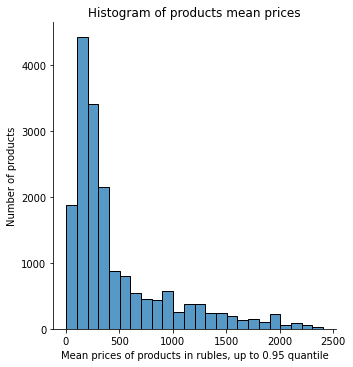

In [531]:
fig = plt.figure(figsize=(20,8))
sns.displot(
    data=hist_data,
    x='mean_price',
    binwidth=100
)
plt.title('Histogram of products mean prices')
plt.xlabel('Mean prices of products in rubles, up to 0.95 quantile')
plt.ylabel('Number of products')
plt.savefig(os.path.join(output_data_plots_path, 'mean_prices_products_histogram.png'))
plt.show()

Histogram with outliers

<Figure size 1440x576 with 0 Axes>

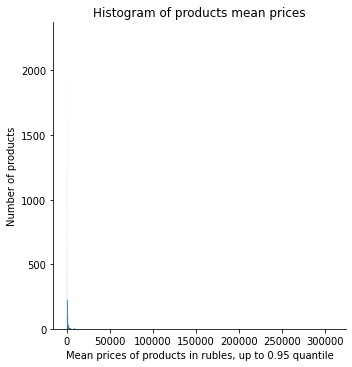

In [532]:
fig = plt.figure(figsize=(20,8))
sns.displot(
    data=mean_prices_pandas_df,
    x='mean_price',
   # binwidth=100
)
plt.title('Histogram of products mean prices')
plt.xlabel('Mean prices of products in rubles, up to 0.95 quantile')
plt.ylabel('Number of products')
plt.show()

Well, the decision to get rid of outliers was a correct decision, let's see who are they

In [533]:
mean_prices_pandas_df[mean_prices_pandas_df['mean_price'] > quantile_095].head(20)

,item_id,mean_price,item_name,item_id,item_category_id
0,6066,307980.000000,Radmin 3 - 522 лиц.,6066,75
1,13199,50999.000000,Коллекционные шахматы (Властелин Колец),13199,69
2,7238,42000.000000,UserGate Proxy & Firewall 6.X до 100 сессий,7238,75
3,14173,40900.000000,Лицензия 1С-Битрикс: Управление сайтом - Эксперт,14173,75
4,5748,35132.857143,Photoshop 13 Windows Russian BOX,5748,75
5,2410,34713.500000,CorelDRAW Graphics Suite X6 - Small Business E...,2410,75
6,3143,29700.000000,ESET NOD32 Smart Security Business Edition new...,3143,75
7,5909,28990.000000,Project 2013 32-bit/x64 Russian CEE DVD,5909,75
8,476,28050.000000,1С:Бухгалтерия 8 ПРОФ на 5 польз. Поставка для...,476,73
9,102,27900.000000,1С-Битрикс: Управление сайтом - Малый бизнес [...,102,76


The outliers are some big SW packages and huge console sets that are not sold in big quantities

### Categories average

In order to process data about categories, we also have to join our logs with categories information

In [539]:
join_1 = cum_sales_df_filtered.join(
    items_df,
    cum_sales_df_filtered.item_id == items_df.item_id,
    'inner'
).drop(items_df.item_id)

final_join = join_1.join(
    categories_df,
    categories_df.item_category_id == join_1.item_category_id,
    'inner'
).drop(join_1.item_category_id)


In [540]:
categories_sum = final_join.groupby(
    'item_category_id', 'item_category_name'
).agg(
    sf.sum('item_cnt_day').alias('sales_sum')
)

categories_sum = categories_sum.sort(categories_sum.sales_sum.desc())

In [541]:
top_5_categories_df = categories_sum.limit(5).toPandas()
top_5_categories = top_5_categories_df.item_category_id.tolist()

top_5_categories_df

,item_category_id,item_category_name,sales_sum
0,40,Кино - DVD,533019.0
1,30,Игры PC - Стандартные издания,382357.0
2,55,Музыка - CD локального производства,280002.0
3,19,Игры - PS3,217336.0
4,37,Кино - Blu-Ray,162525.0


In [542]:
top_5_categories_sales_df = final_join.filter(final_join.item_category_id.isin(top_5_categories))

top_5_categories_sales_df = top_5_categories_sales_df.select(
    top_5_categories_sales_df.item_id,
    top_5_categories_sales_df.item_category_id,
    top_5_categories_sales_df.item_category_name,
    top_5_categories_sales_df.item_price,
    top_5_categories_sales_df.item_name
)

In [543]:
cat_mean_prices_df = top_5_categories_sales_df.groupby(
    'item_id', 'item_category_id', 'item_category_name', 'item_name'
).agg(
    sf.mean('item_price').alias('mean_price')
)

cat_mean_prices_df = cat_mean_prices_df.sort(cat_mean_prices_df.mean_price.desc())
#cat_mean_top_10 = cat_mean_prices_df.take(10)

mean_cat_prices_pandas_df = cat_mean_prices_df.toPandas()

mean_cat_prices_pandas_df.to_csv(os.path.join(output_data_folder, 'mean_category_prices_top_5.csv'))

Since we have several aggregate categories, we cannot apply the same logic for outliers filtering as we did in mean product prices. That's why we clean the data frame step by step for each category and then construct the new one to plot

In [544]:
hist_df_list = []

for category in top_5_categories:
    cat_extract = mean_cat_prices_pandas_df[mean_cat_prices_pandas_df['item_category_id'] == category]
    quantile = cat_extract.mean_price.quantile(0.95)
    cat_extract = cat_extract[cat_extract.mean_price <= quantile]
    
    hist_df_list.append(cat_extract)
    
hist_df = pd.concat(hist_df_list)

In [545]:
hist_df

,item_id,item_category_id,item_category_name,item_name,mean_price
1808,17138,40,Кино - DVD,ПОБУДЬ В МОЕЙ ШКУРЕ,393.978027
1809,16970,40,Кино - DVD,ПЕРЕКРЕСТНЫЙ ОГОНЬ,393.965937
1810,14586,40,Кино - DVD,МИДДЛТОН,393.949153
1812,21419,40,Кино - DVD,ХОТЕЛ БЫ Я БЫТЬ ЗДЕСЬ,393.910769
1813,15749,40,Кино - DVD,НИМФОМАНКА: ЧАСТЬ 2,393.903486
...,...,...,...,...,...
9319,10013,37,Кино - Blu-Ray,ВОЛЬФ МЕССИНГ э. (BD),28.000000
9320,10009,37,Кино - Blu-Ray,ВОЛЬНЫЕ СТРЕЛКИ э. (BD),28.000000
9321,11164,37,Кино - Blu-Ray,ДОМ ВДРЕБЕЗГИ э (BD),28.000000
9577,12089,37,Кино - Blu-Ray,ИСЧЕЗНОВЕНИЕ э. (BD),27.857143


This is irrelevant statistic telling nothing about our data

In [546]:
#hist_df.mean_price.describe()

This is how it has to be done for each category

In [547]:
cat_index = 0

hist_df_list[cat_index].mean_price.describe()

count    4242.000000
mean      185.153005
std       100.616604
min        22.400000
25%       128.600000
50%       145.471752
75%       265.933562
max       393.978027
Name: mean_price, dtype: float64

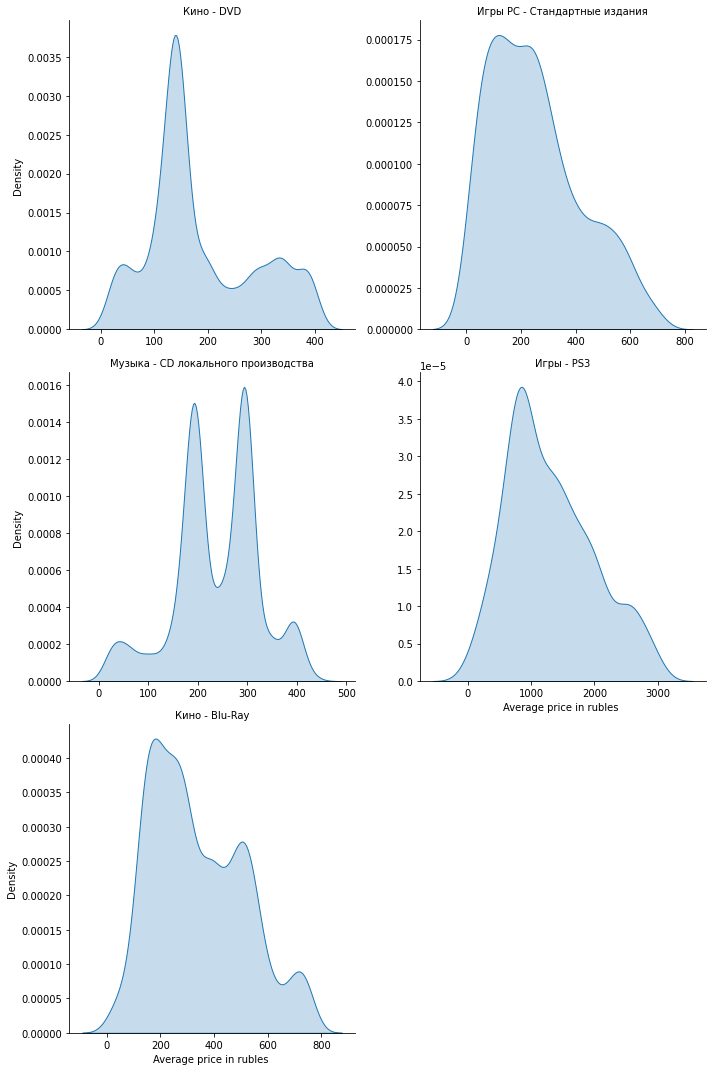

In [548]:
g = sns.displot(
    hist_df,
    x='mean_price',
    col='item_category_name',
    kind='kde',
    col_wrap=2,
    fill=True,
    facet_kws={
        'sharey':False,
        'sharex':False
    }
)

g.set_axis_labels("Average price in rubles ", "Density")
g.set_titles(col_template="{col_name}")

plt.savefig(os.path.join(output_data_plots_path, 'mean_prices_categories_kde_histogram.png'))

The graphs above show some kind of stability in mean prices in games categories (PC games and PS3 games), whereas movies categories have "heavier tails" of their distributions. It's expected that Blu-Ray films have average prices a little bit higher than DVDs since they are considered to be of better quality. CD disks with music have to distinct peaks and two interesting tails, which may be understood as a mixture of two distributions. A more thorough analysis has to be done in order to understand the underlying factors of such a distribution.

### Average category price

In [549]:
categories_prices = final_join.select('item_category_id', 'item_category_name', 'item_price')

In [550]:
categories_mean_prices = categories_prices.groupby(
    'item_category_id', 'item_category_name'
).agg(
    sf.mean('item_price').alias('mean_price')
)
categories_mean_prices = categories_mean_prices.sort(categories_mean_prices.mean_price.desc())

In [551]:
categories_mean_prices_pd_df = categories_mean_prices.toPandas()

categories_mean_prices_pd_df.to_csv(os.path.join(output_data_folder, 'mean_price_for_category.csv'))

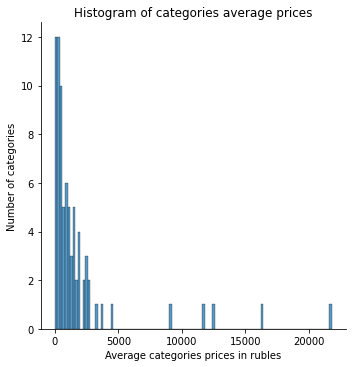

In [552]:
#plt.hist(hist_data.mean_price, density=False, bins=30)  # density=False would make counts
sns.displot(
    data=categories_mean_prices_pd_df,
    x='mean_price',
    binwidth=200
)
plt.title('Histogram of categories average prices')
plt.xlabel('Average categories prices in rubles')
plt.ylabel('Number of categories')
plt.savefig(os.path.join(output_data_plots_path, 'mean_category_price_histogram.png'))
plt.show()

What do we see here? Our categories are a little bit unbalanced in terms of mean prices of the products that are sold in them. While most of our products build the left side of the histogram, there are some categories having much higher price range. Let's examine which categories are in the right part of the picture.

In [553]:
cat_mean_prices_top_10 = categories_mean_prices.limit(10)
cat_mean_prices_top_10 = cat_mean_prices_top_10.toPandas()

In [554]:
cat_mean_prices_top_10

,item_category_id,item_category_name,mean_price
0,12,Игровые консоли - PS4,21791.317350
1,16,Игровые консоли - XBOX ONE,16283.346020
2,11,Игровые консоли - PS3,12567.533106
3,15,Игровые консоли - XBOX 360,11764.560647
4,14,Игровые консоли - PSVita,9180.829925
5,13,Игровые консоли - PSP,4560.880948
6,74,Программы - MAC (Цифра),3617.352941
7,60,Музыка - Подарочные издания,3209.262687
8,20,Игры - PS4,2676.184495
9,7,Аксессуары - XBOX ONE,2637.161626


Due to the fact that our shops mostly sell disks with PC and console games and other stuff like films, DVDs and CD disks with music and since these items account for the most of the whole assortiment, most of categories' average prices are below 2000 Russian rubles. However, not only do we sell disks, but also some consoles and software which cost much more than an average CD disk. That's the reason for having several categories with much higher average price range.

## Top 10 overall sales products for AX, BX, CZ categories

First of all, we have to combine two data frames with XYZ and ABC classifications

In [555]:
xyz_classification_df.show()

+-------+------------------+------------------+---------+---+
|item_id|              mean|               std|var_coeff|XYZ|
+-------+------------------+------------------+---------+---+
|   9968| 2.111111111111111|1.0999438818457405|    0.521|  Z|
|    964| 5.176470588235294|3.3119266494727646|     0.64|  Z|
|  15437| 2.142857142857143| 1.505093393264677|    0.702|  Z|
|   8484|               6.0|3.1207579904219758|     0.52|  Z|
|  14719|              12.8|  8.62322445492404|    0.674|  Z|
|  11938|21.291666666666668| 9.502101375777652|    0.446|  Z|
|  14117|12.583333333333334| 8.489781439406368|    0.675|  Z|
|  19771|              83.0| 148.4833125898229|    1.789|  Z|
|  20532|               3.0|1.7638342073763937|    0.588|  Z|
|  15375|12.071428571428571| 21.87452623393667|    1.812|  Z|
|  13098|             60.75|26.147418610639175|     0.43|  Z|
|  21899|               1.2|               0.4|    0.333|  Z|
|   1806|               1.0|               0.0|      0.0|  X|
|   9715

In [556]:
cum_sales_df_abc.show()

+-------+------------+--------+----------+---+
|item_id|item_cnt_day|  cumsum|percentage|ABC|
+-------+------------+--------+----------+---+
|  20949|    149053.0|149053.0|     0.052|  A|
|   2808|     16252.0|165305.0|     0.057|  A|
|   3732|     15831.0|181136.0|     0.063|  A|
|   3734|     10851.0|191987.0|     0.066|  A|
|   5822|     10389.0|202376.0|      0.07|  A|
|   6675|      9319.0|211695.0|     0.073|  A|
|   1855|      9247.0|220942.0|     0.076|  A|
|  16787|      8912.0|229854.0|      0.08|  A|
|  17717|      8562.0|238416.0|     0.083|  A|
|   3331|      7716.0|246132.0|     0.085|  A|
|   7856|      7623.0|253755.0|     0.088|  A|
|   2814|      7097.0|260852.0|      0.09|  A|
|   2445|      7041.0|267893.0|     0.093|  A|
|   6738|      6871.0|274764.0|     0.095|  A|
|   1830|      6863.0|281627.0|     0.097|  A|
|   4181|      6425.0|288052.0|       0.1|  A|
|   4870|      6049.0|294101.0|     0.102|  A|
|   3183|      5913.0|300014.0|     0.104|  A|
|   6740|    

Join these data frames into one big data frame

In [557]:
cum_sales_big_df = xyz_classification_df.join(
    cum_sales_df_abc,
    xyz_classification_df.item_id == cum_sales_df_abc.item_id,
    'inner'
).drop(cum_sales_df_abc.item_id)

Calculate total sale for each product

In [558]:
cum_sales_big_df_total_sale = cum_sales_df_filtered.withColumn('total_sale', cum_sales_df_filtered.item_price * cum_sales_df_filtered.item_cnt_day)

In [559]:
total_sale_df = cum_sales_big_df_total_sale.groupby('item_id').agg(sf.sum('total_sale').alias('total_sale'))

Join this data to create ABC/XYZ classes

In [560]:
final_df_joined = cum_sales_big_df.join(
    total_sale_df,
    cum_sales_big_df.item_id == total_sale_df.item_id,
    'inner'
).drop(total_sale_df.item_id)

## Categories

Here the process in pretty straightforward and identical for all three categories:

1. Filter out products belonging to the category of interest
2. Select only relevant columns
3. Join the resulting data frame with items dataframe so that we have products' readable names
4. Sort the final data frame by final sales column in a descending order so that we select top 10 products with the highest sales
5. Convert these 10 rows into Pandas dataframe, save it as a CSV report file and show here in the notebook

### AX category

In [561]:
ax_final_sales = final_df_joined.filter(
    (final_df_joined.ABC == 'A') & (final_df_joined.XYZ == 'X')
)

ax_final_sales = ax_final_sales.select('item_id', 'abc', 'xyz', 'total_sale')
ax_final_sales_with_names = ax_final_sales.join(items_df, ax_final_sales.item_id == items_df.item_id).drop(items_df.item_id)

ax_final_sales_top_10 = ax_final_sales_with_names.sort(ax_final_sales_with_names.total_sale.desc()).limit(10)


In [562]:
ax_final_sales_top_10 = ax_final_sales_top_10.toPandas()
ax_final_sales_top_10.to_csv(os.path.join(output_data_folder, 'top_10_products_by_sale_in_ax.csv'))

In [563]:
ax_final_sales_top_10

,item_id,abc,xyz,total_sale,item_name,item_category_id
0,3027,A,X,3144510.11,"Dragon Age: Инквизиция [PS4, русские субтитры]",20
1,2430,A,X,1995599.36,"Crew. Специальное издание [PS4, русская версия]",20
2,2429,A,X,1766270.57,"Crew. Специальное издание [PC, русская версия]",28
3,3735,A,X,1477109.95,"Grand Theft Auto V [Xbox One, русские субтитры]",24
4,1565,A,X,1274528.95,"Assassin's Creed: Изгой [Xbox 360, русская вер...",23
5,5490,A,X,579748.30,PINK FLOYD The Endless River (фирм.),56
6,2813,A,X,505930.55,"Diablo III: Reaper of Souls (дополнение) [PC, ...",28
7,14142,A,X,181524.27,ЛЮСИ,40
8,21669,A,X,136220.30,ЧЕРЕПАШКИ-НИНДЗЯ,40


The most stable goods accounting for the most profitable sales are console and PC games by popular vendors. We also see that our shop is regularly visited by people with great music preferences since they buy the film about Pink Floyd  :)

### BX category

In [564]:
bx_final_sales = final_df_joined.filter(
    (final_df_joined.ABC == 'B') & (final_df_joined.XYZ == 'X')
)

bx_final_sales = bx_final_sales.select('item_id', 'abc', 'xyz', 'total_sale')
bx_final_sales_with_names = bx_final_sales.join(items_df, bx_final_sales.item_id == items_df.item_id).drop(items_df.item_id)

bx_final_sales_top_10 = bx_final_sales_with_names.sort(bx_final_sales_with_names.total_sale.desc()).limit(10)


In [565]:
bx_final_sales_top_10_pd = bx_final_sales_top_10.toPandas()
bx_final_sales_top_10_pd.to_csv(os.path.join(output_data_folder, 'top_10_products_by_sale_in_bx.csv'))

In [566]:
bx_final_sales_top_10_pd

,item_id,abc,xyz,total_sale,item_name,item_category_id
0,7982,B,X,3286970.96,Xbox One 500 ГБ + Assassins Creed Единство + A...,16
1,5666,B,X,883470.70,PS4: Контроллер игровой беспроводной белый (Du...,3
2,2878,B,X,714729.75,Disney. Infinity 2.0 (Marvel). Стартовый набор...,23
3,1541,B,X,666346.63,Assassin's Creed: Единство. Bastille Edition [...,29
4,2876,B,X,623743.75,Disney. Infinity 2.0 (Marvel). Стартовый набор...,19
5,3464,B,X,529863.00,"Far Cry 4. Специальное издание [Xbox One, русс...",24
6,1233,B,X,489941.50,AC/DC Rock Or Bust (фирм.),56
7,4869,B,X,335638.00,"Minecraft [PS Vita, русская версия]",22
8,3443,B,X,249407.70,"Far Cry 4 [PC, русская версия]",30
9,14143,B,X,225524.27,ЛЮСИ (BD),37


Here we already see not only some games for PC and PS/XBOX, but also for more budget consoles like PS Vita, we also see the representatives of PS4 accessories. It means that these items are less stable in our sales, but still considerably constribute to our shop's wellbeing.

### CZ category

In [567]:
cz_final_sales = final_df_joined.filter(
    (final_df_joined.ABC == 'C') & (final_df_joined.XYZ == 'X')
)

cz_final_sales = cz_final_sales.select('item_id', 'abc', 'xyz', 'total_sale')
cz_final_sales_with_names = cz_final_sales.join(items_df, cz_final_sales.item_id == items_df.item_id).drop(items_df.item_id)

cz_final_sales_top_10 = cz_final_sales_with_names.sort(cz_final_sales_with_names.total_sale.desc()).limit(10)


In [568]:
cz_final_sales_top_10_pd = cz_final_sales_top_10.toPandas()
cz_final_sales_top_10_pd.to_csv(os.path.join(output_data_folder, 'top_10_products_by_sale_in_cz.csv'))

In [569]:
cz_final_sales_top_10_pd

,item_id,abc,xyz,total_sale,item_name,item_category_id
0,13406,C,X,1265321.80,"Комплект ""Microsoft Xbox One 500GB"" + ""Xbox On...",16
1,13465,C,X,477449.00,Комплект «Sony PS Vita 2000 WiFi Black Rus (PC...,14
2,7723,C,X,427681.82,"WWE 2K15 [PS3, русская документация]",19
3,5902,C,X,367405.00,"Pro Evolution Soccer 2015 [PS4, русские субтитры]",20
4,2424,C,X,345191.00,"Crew [Xbox 360, русская версия]",23
5,2877,C,X,334898.15,Disney. Infinity 2.0 (Marvel). Стартовый набор...,20
6,13494,C,X,310790.00,Комплект «Sony PS3 Super Slim (500 Gb) (CECH-4...,11
7,6066,C,X,307980.00,Radmin 3 - 522 лиц.,75
8,4998,C,X,300651.06,"NBA 2K15 [Xbox 360, английская версия]",23
9,7725,C,X,271219.00,"WWE 2K15 [Xbox 360, русская документация]",23


There are some console games here as well, but I cannot say that they are somehow popular. We also see more sets here (Xbox One set) and (Sony PS Vita set), which proves that these sales are less frequent. 

## Total sales w.r.t days, weeks, months

In [570]:
### Resolve column names differences
if 'date' in cum_sales_big_df_total_sale.columns:
    cum_sales_big_df_total_sale = cum_sales_big_df_total_sale.withColumnRenamed('date', 'sale_date')


First of all, we will calculate total sale with respect to each day present in the report.
We also preserve month_num column since it will help us orient in different months later

In [571]:
total_price_to_date_df = cum_sales_big_df_total_sale.groupby('sale_date', 'month_num').agg(
    sf.sum('total_sale').alias('total_daily_sale')
)

number_of_days_in_the_dataset = total_price_to_date_df.count()

print(f'Days logged in the dataset: {number_of_days_in_the_dataset}')

Days logged in the dataset: 730


We have not so many rows, so let's convert this data frame into Pandas data frame

In [572]:
total_price_to_date_pandas_df = total_price_to_date_df.toPandas()

We will greately benefit from Pandas' DateTime data type since it provides lots of methods of converting date and time and also perform "datetime" arithmetics, making the whole analytical process much easier

In [573]:
total_price_to_date_pandas_df.dtypes

sale_date           datetime64[ns]
month_num                    int64
total_daily_sale           float64
dtype: object

One more advantage of working with DateTime columns is the ability to sort these columns in hierarchical order

In [574]:
total_price_to_date_pandas_df = total_price_to_date_pandas_df.sort_values(by=['sale_date'], ascending=True,).reset_index(drop=True)

total_price_to_date_pandas_df.to_csv(os.path.join(output_data_folder, 'total_price_to_date.csv'))

In [575]:
total_price_to_date_pandas_df

,sale_date,month_num,total_daily_sale
0,2013-01-01,0,1371116.50
1,2013-01-02,0,6070414.01
2,2013-01-03,0,5460386.50
3,2013-01-04,0,4769843.50
4,2013-01-05,0,4600005.40
...,...,...,...
725,2014-12-27,23,15685395.60
726,2014-12-28,23,12478215.00
727,2014-12-29,23,11136209.40
728,2014-12-30,23,17041863.00


Our next task is to compute the week number since we also want to aggregate sales information with respect to weeks.

The algorithm is almost trivial: take the very first date available in the data frame, determine the day of the week from the date and subtract this date by the ordinal number of this day w.r.t. the week. By doing so we will get the date of the closest Monday preceeding this particular date. This Monday will be the "baseline" date.

In [576]:
total_price_to_date_pandas_df['sale_date'] = pd.to_datetime(total_price_to_date_pandas_df['sale_date'])

date_1 = total_price_to_date_pandas_df['sale_date'][0]
monday_start = date_1 -  pd.Timedelta(days = date_1.weekday())

print(f'The first date in our sales log is {date_1}')
print(f'The closest Monday preceeding this day is on {monday_start}')

The first date in our sales log is 2013-01-01 00:00:00
The closest Monday preceeding this day is on 2012-12-31 00:00:00


And now with the help of simple calculations we obtain the week number for each entry in the sales data frame

In [577]:
def get_relative_week_num(date_2, start_monday_date):
    monday_2 = date_2 - pd.Timedelta(days = date_2.weekday())
    diff = (monday_2 - start_monday_date).days
    
    return diff // 7

pd_week_func = lambda date: get_relative_week_num(date, monday_start)
    

Add new column "week_num" and show the resulting data frame

In [578]:
total_price_to_date_pandas_df['week_num'] = total_price_to_date_pandas_df['sale_date'].apply(pd_week_func)

total_price_to_date_pandas_df

,sale_date,month_num,total_daily_sale,week_num
0,2013-01-01,0,1371116.50,0
1,2013-01-02,0,6070414.01,0
2,2013-01-03,0,5460386.50,0
3,2013-01-04,0,4769843.50,0
4,2013-01-05,0,4600005.40,0
...,...,...,...,...
725,2014-12-27,23,15685395.60,103
726,2014-12-28,23,12478215.00,103
727,2014-12-29,23,11136209.40,104
728,2014-12-30,23,17041863.00,104


The last step is to get the relative day number. It's even more trivial than with the weeks

In [579]:
pd_relative_days_func = lambda date: (date - date_1).days

In [580]:
total_price_to_date_pandas_df['day_num'] = total_price_to_date_pandas_df['sale_date'].apply(pd_relative_days_func)

total_price_to_date_pandas_df

,sale_date,month_num,total_daily_sale,week_num,day_num
0,2013-01-01,0,1371116.50,0,0
1,2013-01-02,0,6070414.01,0,1
2,2013-01-03,0,5460386.50,0,2
3,2013-01-04,0,4769843.50,0,3
4,2013-01-05,0,4600005.40,0,4
...,...,...,...,...,...
725,2014-12-27,23,15685395.60,103,725
726,2014-12-28,23,12478215.00,103,726
727,2014-12-29,23,11136209.40,104,727
728,2014-12-30,23,17041863.00,104,728


Change columns order for more logical view

In [581]:
total_price_to_date_pandas_df = total_price_to_date_pandas_df[total_price_to_date_pandas_df.columns[[0, -1, -2, 1, 2]]]
total_price_to_date_pandas_df

,sale_date,day_num,week_num,month_num,total_daily_sale
0,2013-01-01,0,0,0,1371116.50
1,2013-01-02,1,0,0,6070414.01
2,2013-01-03,2,0,0,5460386.50
3,2013-01-04,3,0,0,4769843.50
4,2013-01-05,4,0,0,4600005.40
...,...,...,...,...,...
725,2014-12-27,725,103,23,15685395.60
726,2014-12-28,726,103,23,12478215.00
727,2014-12-29,727,104,23,11136209.40
728,2014-12-30,728,104,23,17041863.00


In order to get fancier visualisations, we will make use of some formatters and tickers in matplotlib library

In [582]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

day_locator = mdates.DayLocator((1,10, 20,))
week_locator = ticker.MultipleLocator(10)
month_locator = mdates.MonthLocator()

formatter_func = lambda x, pos: f'{x/10**6:,.0f}M'
formatter = ticker.FuncFormatter(formatter_func)


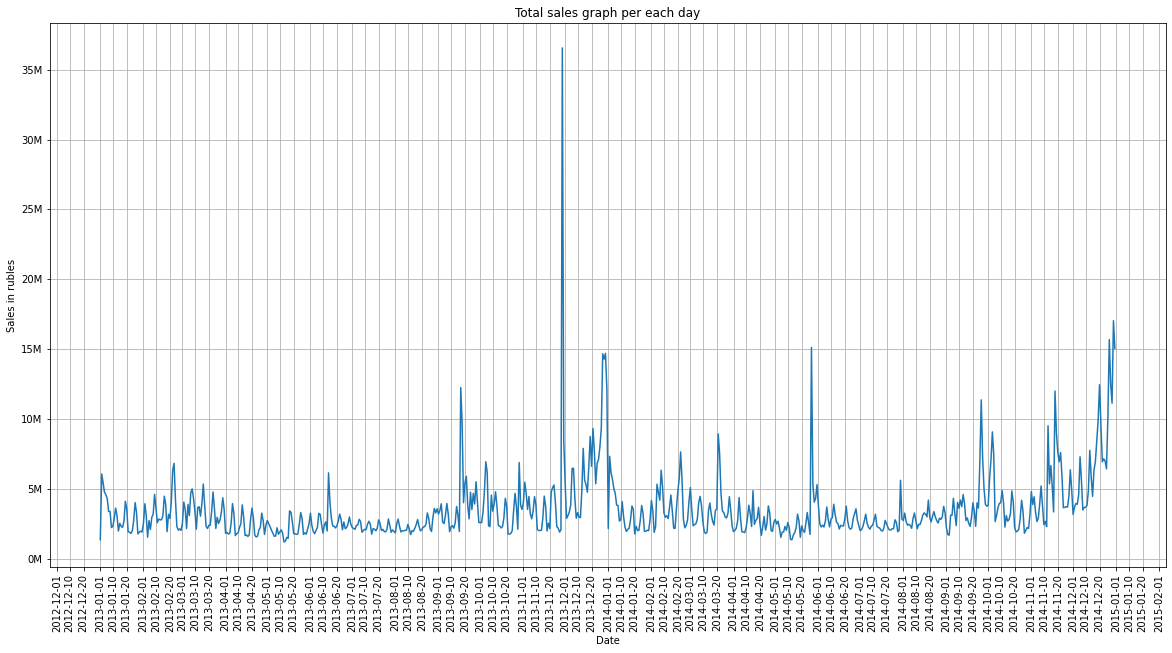

In [583]:
fig = plt.figure(figsize=(20,10))

ax = sns.lineplot(
    data=total_price_to_date_pandas_df,
    x='sale_date',
    y='total_daily_sale'
)
ax.xaxis.set_major_locator(day_locator)
ax.yaxis.set_major_formatter(formatter)

plt.xticks(rotation=90)
plt.grid()
plt.title('Total sales graph per each day')
plt.xlabel('Date')
plt.ylabel('Sales in rubles')
plt.savefig(os.path.join(output_data_plots_path, 'sales_per_each_day.png'))
plt.show()

By looking at this graph we can see that there are several peaks. The most distinct one is near the end of 2013 and might be explained by the approaching New Year's holidays. Lots of people buy presents, so the reason for such a rise in sales can be just a reflection of this fact.

There are also some smaller peaks near the end of February and the beginning of March. There are also 2 major holidays for men (23.02) and women (08.03), this may play some role in such fluctuations.

There is even bigger peak just at the end of spring and the beginning of summer. I can explain it by possible higher correlation of number of console and PC games sold and the fact that children and youngsters finish their studies. I'm almost 100% sure there is positive and strong correlation between these two variables. That's wht the number of sales rose for a short period of time.

Some peaks in the middle of the autumn are not connected to any particular and important holiday in Russia. Then, it is probably due to some discounts or final sales before buying newer goods/games before the next New Year hot season. It might also be due to some major events in game or movie industry (the unveiling of new PlayStation or new XBox with some new exlusive games in parallel).

By the end of the next year we also see the rising trend of sales since there are new holidays in a stone's throw and lots of people again have to buy presents.

#### Weekly data visualisation

In [584]:
weekly_sales_df = total_price_to_date_pandas_df[['sale_date', 'week_num', 'total_daily_sale']].groupby(
    'week_num'
).agg(
{'sale_date': np.min, 'total_daily_sale': np.sum}
).rename(
    columns=
    {
        'sale_date': 'week_start_date',
        'total_daily_sale': 'weekly_sale'
    }
)

weekly_sales_df

,week_start_date,weekly_sale
week_num,,
0,2013-01-01,2.656037e+07
1,2013-01-07,2.095580e+07
2,2013-01-14,1.949214e+07
3,2013-01-21,1.780051e+07
4,2013-01-28,1.718484e+07
...,...,...
100,2014-12-01,3.221610e+07
101,2014-12-08,3.322172e+07
102,2014-12-15,5.810054e+07


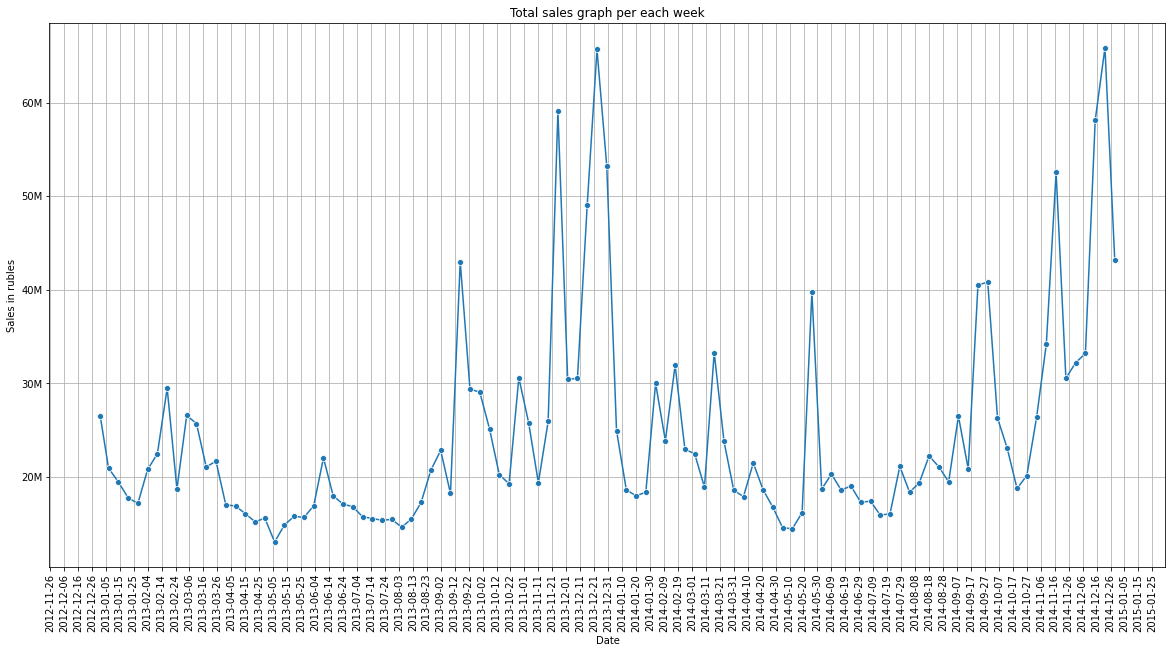

In [585]:
fig = plt.figure(figsize=(20,10))

ax = sns.lineplot(
    data=weekly_sales_df,
    x='week_start_date',
    y='weekly_sale',
    marker = 'o'
)
ax.xaxis.set_major_locator(week_locator);
ax.yaxis.set_major_formatter(formatter)

plt.xticks(rotation=90)
plt.grid()
plt.title('Total sales graph per each week')
plt.xlabel('Date')
plt.ylabel('Sales in rubles')
plt.savefig(os.path.join(output_data_plots_path, 'sales_per_each_weak.png'))
plt.show()


In my opinion, this graph is even more informative than the previous one since one day is not particularly good time span for seeing some tendencies. A weekly span has an advantage of encompassing weekends and the "mood" for the current week. Obviously, the "mood" of the week before the New Year's holidays and the "mood" the very first week after them are too different and we see it in the graph as well. Weeks are less prone to radical fluctuations and show more general trend, whereas day-to-day data show more variety which is mostly preserved in weekly data and is easier to look at.

By looking at this graph, we see that two most considerable peaks are drawn tighlty before the New Year's holidays. These peaks are clearer than those in the preceeding graph. The peak at the beginning of summer is also depicted here, which once more shows some evidence of strong factors playing its role on total sales in our shop.

#### Monthly sales visualisation

In [586]:
monthly_sales_df = total_price_to_date_pandas_df[['sale_date', 'month_num', 'total_daily_sale']].groupby(
    'month_num'
).agg(
{'sale_date': np.min, 'total_daily_sale': np.sum}
).rename(
    columns=
    {
        'sale_date': 'month_start_date',
        'total_daily_sale': 'monthly_sale'
    }
)

monthly_sales_df

,month_start_date,monthly_sale
month_num,,
0,2013-01-01,9.239909e+07
1,2013-02-01,9.096449e+07
2,2013-03-01,1.052654e+08
3,2013-04-01,6.945713e+07
4,2013-05-01,6.525317e+07
5,2013-06-01,7.976249e+07
6,2013-07-01,6.953452e+07
7,2013-08-01,7.458699e+07
8,2013-09-01,1.193180e+08


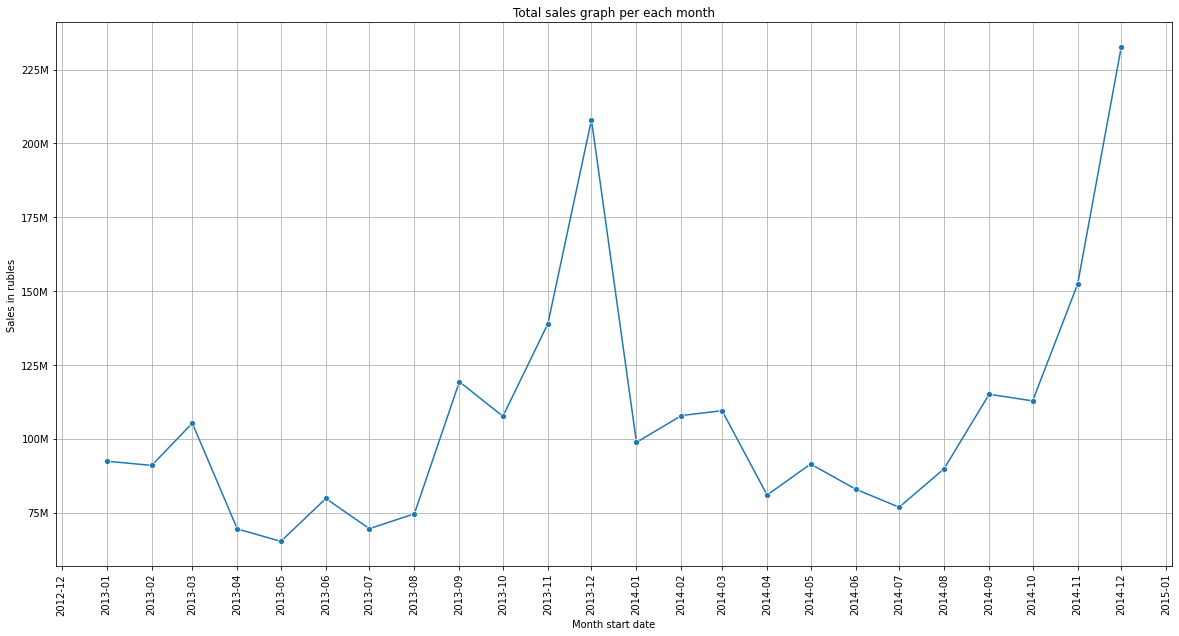

In [587]:
fig = plt.figure(figsize=(20,10))

ax = sns.lineplot(
    data=monthly_sales_df,
    x='month_start_date',
    y='monthly_sale',
    marker = 'o'
)
ax.xaxis.set_major_locator(month_locator)
ax.yaxis.set_major_formatter(formatter)

plt.xticks(rotation=90)
plt.grid()
plt.title('Total sales graph per each month')
plt.xlabel('Month start date')
plt.ylabel('Sales in rubles')
plt.savefig(os.path.join(output_data_plots_path, 'sales_per_each_month.png'))
plt.show()


In fact, nothing really suprising. Again, two peaks at the end of each year, slightly more sales at the end of winters and a slight rise in sales at the beginning of summer holidays. 

Moreover, we see some gradual and increasing demand after the beginning of Octobers. It may signalize that many people start buying presents in advance, so the message for our supply department may be pretty straightforward: we have to get ready to the higher demands and "...wake up when September ends" (c) Green Day.

### Day of week sales, day of month sales, week in year sales, month in year sales

#### Day of the week

In [588]:
pd_day_of_the_week_func = lambda date: date.dayofweek

total_price_to_date_pandas_df['day_of_the_week'] = total_price_to_date_pandas_df['sale_date'].apply(pd_day_of_the_week_func)
total_price_to_date_pandas_df

/Users/fluffy/anaconda3/envs/BDT/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,sale_date,day_num,week_num,month_num,total_daily_sale,day_of_the_week
0,2013-01-01,0,0,0,1371116.50,1
1,2013-01-02,1,0,0,6070414.01,2
2,2013-01-03,2,0,0,5460386.50,3
3,2013-01-04,3,0,0,4769843.50,4
4,2013-01-05,4,0,0,4600005.40,5
...,...,...,...,...,...,...
725,2014-12-27,725,103,23,15685395.60,5
726,2014-12-28,726,103,23,12478215.00,6
727,2014-12-29,727,104,23,11136209.40,0
728,2014-12-30,728,104,23,17041863.00,1


In [589]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

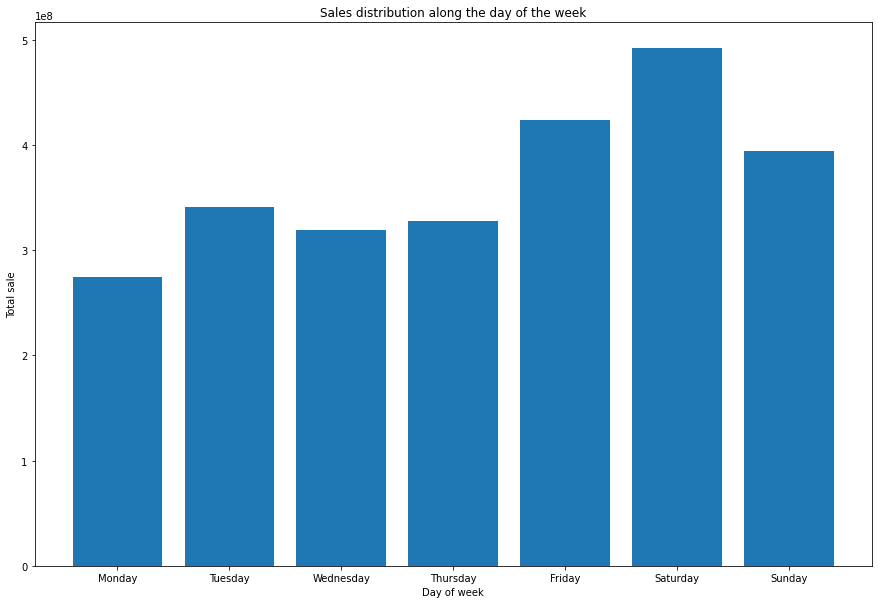

In [590]:
plt.figure(figsize=(15, 10))

agg_df = total_price_to_date_pandas_df[
    ['day_of_the_week', 'total_daily_sale']
].groupby('day_of_the_week').sum()

plt.bar(agg_df.index, agg_df['total_daily_sale'])
plt.title('Sales distribution along the day of the week')
plt.xlabel('Day of week')
plt.xticks(list(range(len(weekdays))), labels = weekdays)
plt.ylabel('Total sale')
plt.savefig(os.path.join(output_data_plots_path, 'sales_per_each_day_of_the_week.png'))
plt.show()

Nothing really surprising here. We sell more goods over the weekend, since kinds and youngsters mostly do not buy games for themselves and employ their parents who mostly work from Monday to Friday and have more time during the weekends. Here we can clearly see evidence for my hypothesis. 

#### Day of the month

In [591]:
pd_day_of_the_month_func = lambda date: date.day

total_price_to_date_pandas_df['day_of_the_month'] = total_price_to_date_pandas_df['sale_date'].apply(pd_day_of_the_month_func)
total_price_to_date_pandas_df

/Users/fluffy/anaconda3/envs/BDT/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,sale_date,day_num,week_num,month_num,total_daily_sale,day_of_the_week,day_of_the_month
0,2013-01-01,0,0,0,1371116.50,1,1
1,2013-01-02,1,0,0,6070414.01,2,2
2,2013-01-03,2,0,0,5460386.50,3,3
3,2013-01-04,3,0,0,4769843.50,4,4
4,2013-01-05,4,0,0,4600005.40,5,5
...,...,...,...,...,...,...,...
725,2014-12-27,725,103,23,15685395.60,5,27
726,2014-12-28,726,103,23,12478215.00,6,28
727,2014-12-29,727,104,23,11136209.40,0,29
728,2014-12-30,728,104,23,17041863.00,1,30


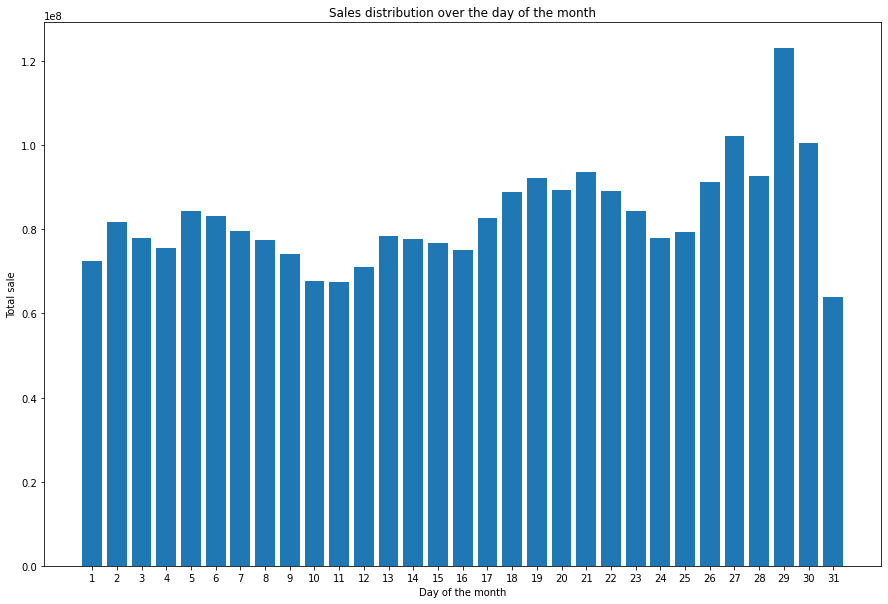

In [592]:
plt.figure(figsize=(15, 10))

agg_df = total_price_to_date_pandas_df[
    ['day_of_the_month', 'total_daily_sale']
].groupby('day_of_the_month').sum()

plt.bar(agg_df.index, agg_df['total_daily_sale'])
plt.title('Sales distribution over the day of the month')
plt.xlabel('Day of the month')
plt.xticks(agg_df.index)
plt.ylabel('Total sale')
plt.savefig(os.path.join(output_data_plots_path, 'sales_per_each_day_of_the_month.png'))
plt.show()

I will steer clear from any possible hypotheses concerning this plot... I can only say that I see four distinct "waves" in sales. They maybe have something to do with the fact that there are 4 weeks in each month, but still they are not alligned to some particular date (a month can start on Friday or on any other day of the week, so the data presented here might be misleading). Since we are looking on data from 2 years of selling, it's highly probable that were quite lucky with the allignment.

The only thing that may be relevant to real life after pondering about these results is the fact that most people get paid several days before the end of each month, so they may be less reluctant to buy a new video game or music disk, that's why they may spend more spare money right after getting it.

#### Week of the year

In [593]:
pd_week_of_the_year_func = lambda date: date.weekofyear

total_price_to_date_pandas_df['week_of_the_year'] = total_price_to_date_pandas_df['sale_date'].apply(pd_week_of_the_year_func)
total_price_to_date_pandas_df


/Users/fluffy/anaconda3/envs/BDT/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,sale_date,day_num,week_num,month_num,total_daily_sale,day_of_the_week,day_of_the_month,week_of_the_year
0,2013-01-01,0,0,0,1371116.50,1,1,1
1,2013-01-02,1,0,0,6070414.01,2,2,1
2,2013-01-03,2,0,0,5460386.50,3,3,1
3,2013-01-04,3,0,0,4769843.50,4,4,1
4,2013-01-05,4,0,0,4600005.40,5,5,1
...,...,...,...,...,...,...,...,...
725,2014-12-27,725,103,23,15685395.60,5,27,52
726,2014-12-28,726,103,23,12478215.00,6,28,52
727,2014-12-29,727,104,23,11136209.40,0,29,1
728,2014-12-30,728,104,23,17041863.00,1,30,1


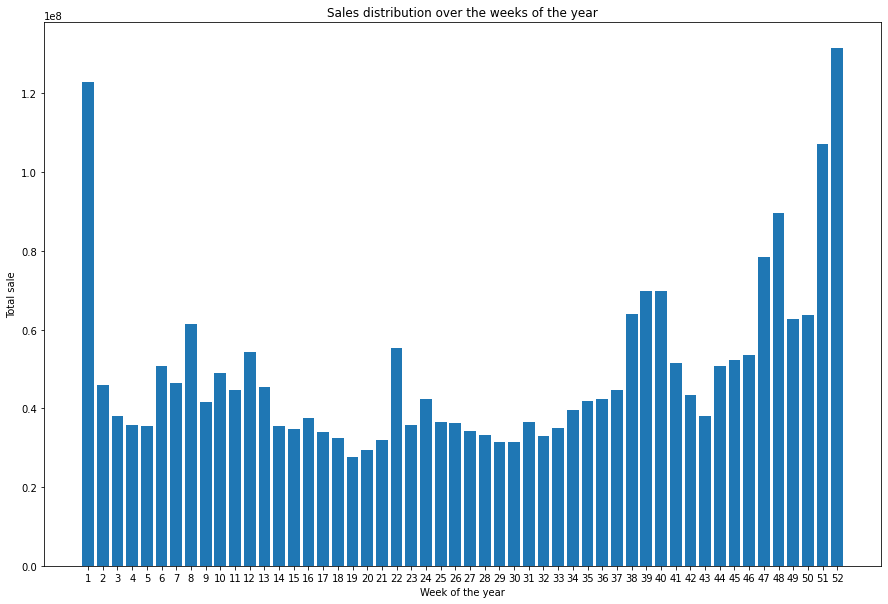

In [594]:
plt.figure(figsize=(15, 10))

agg_df = total_price_to_date_pandas_df[
    ['week_of_the_year', 'total_daily_sale']
].groupby('week_of_the_year').sum()

plt.bar(agg_df.index, agg_df['total_daily_sale'])
plt.title('Sales distribution over the weeks of the year')
plt.xlabel('Week of the year')
plt.xticks(agg_df.index)
plt.ylabel('Total sale')
plt.savefig(os.path.join(output_data_plots_path, 'sales_per_each_week_of_the_year.png'))
plt.show()

This graph is a something of a merge of several years presented above in weekly data. We get the idea of how the year looks like by summing up several years, which may produce a more balanced picture of how our sales are distributed throughout the year. 

The conclusion that can be drawn is pretty similar to the one presented under the weekly sales plot. We see that most sales are achieved at the end of the year with some momentum at the beginning of the next one. Then, we see some rising trend at the beginning of spring and summer. 

In other words, this graphs summarises what we've seen earlier, and significantly improves our visual abilities as soon as we want to assess more than 2-3 years (in such a case, the weekly graph above might become unreadable and cluttered).

#### Month of the year

In [595]:
pd_month_of_the_year_func = lambda date: date.month

total_price_to_date_pandas_df['month_of_the_year'] = total_price_to_date_pandas_df['sale_date'].apply(pd_month_of_the_year_func)
total_price_to_date_pandas_df


/Users/fluffy/anaconda3/envs/BDT/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,sale_date,day_num,week_num,month_num,total_daily_sale,day_of_the_week,day_of_the_month,week_of_the_year,month_of_the_year
0,2013-01-01,0,0,0,1371116.50,1,1,1,1
1,2013-01-02,1,0,0,6070414.01,2,2,1,1
2,2013-01-03,2,0,0,5460386.50,3,3,1,1
3,2013-01-04,3,0,0,4769843.50,4,4,1,1
4,2013-01-05,4,0,0,4600005.40,5,5,1,1
...,...,...,...,...,...,...,...,...,...
725,2014-12-27,725,103,23,15685395.60,5,27,52,12
726,2014-12-28,726,103,23,12478215.00,6,28,52,12
727,2014-12-29,727,104,23,11136209.40,0,29,1,12
728,2014-12-30,728,104,23,17041863.00,1,30,1,12


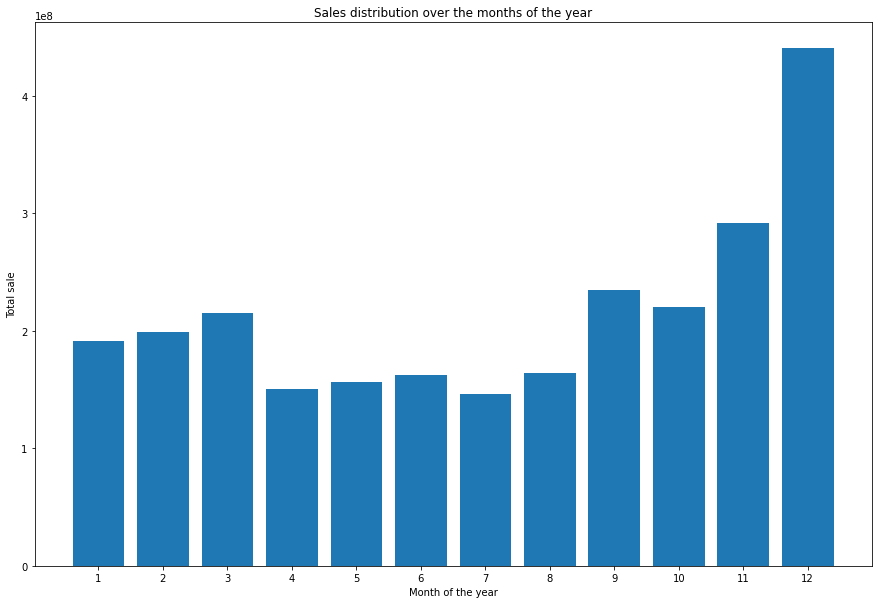

In [596]:
plt.figure(figsize=(15, 10))

agg_df = total_price_to_date_pandas_df[
    ['month_of_the_year', 'total_daily_sale']
].groupby('month_of_the_year').sum()

plt.bar(agg_df.index, agg_df['total_daily_sale'])
plt.title('Sales distribution over the months of the year')
plt.xlabel('Month of the year')
plt.xticks(agg_df.index)
plt.ylabel('Total sale')
plt.savefig(os.path.join(output_data_plots_path, 'sales_per_each_month_of_the_year.png'))
plt.show()

Well, it's one more way how to comfortably and informatively summarize many years in one and present balanced view on the data. We again notice higher demand closer to the end of the year and slowly rising demand till the beginning of the spring (some people buy presents 1-2 months in advance) and even more slowly increasing demand till the 6th month of the year (it's June). 

The 9th months is surprisingly higher in demands compared to both 8th and 10th months. I can hypothesize that there are two possible reasons causing this effect:

1. Children go to school and hence, parents buy them something for school or something to relief their stress.
2. Lots of people are being born in Russia in September (well, we might guess why, but I'm sure that it is due to 10 days of doing nothing during New Year holidays which may result in conveiving a child after impetuous celebrations of both men and women).

## The same as before but just in 5 biggest categories

In [597]:
top_5_categories_ids_list = top_5_categories_sales_df.toPandas().item_category_id.unique()
top_5_categories_ids_list

array([19, 37, 55, 30, 40])

In [598]:
_join = cum_sales_big_df_total_sale.join(
    items_df,
    cum_sales_df_filtered.item_id == items_df.item_id,
    'inner'
).drop(items_df.item_id)

cum_sales_big_df_total_sale_categories = _join.join(
    categories_df,
    categories_df.item_category_id == _join.item_category_id,
    'inner'
).drop(_join.item_category_id)

In [599]:
total_price_to_date_df = cum_sales_big_df_total_sale_categories.filter(
    cum_sales_big_df_total_sale_categories.item_category_id.isin(
        top_5_categories_ids_list.tolist()
    )
).groupby(
    'sale_date',
    'month_num',
    'item_category_id',
    'item_category_name',
).agg(
    sf.sum(
        'total_sale'
    ).alias(
        'total_daily_sale'
    )
)

total_price_to_date_df.count()

3650

In [600]:
total_price_to_date_pd_df = total_price_to_date_df.toPandas()

In [601]:
total_price_to_date_pd_df = total_price_to_date_pd_df.sort_values(by=['sale_date'], ascending=True,).reset_index(drop=True)
total_price_to_date_pd_df

,sale_date,month_num,item_category_id,item_category_name,total_daily_sale
0,2013-01-01,0,30,Игры PC - Стандартные издания,137999.50
1,2013-01-01,0,19,Игры - PS3,231644.83
2,2013-01-01,0,37,Кино - Blu-Ray,40361.15
3,2013-01-01,0,55,Музыка - CD локального производства,43512.00
4,2013-01-01,0,40,Кино - DVD,138818.92
...,...,...,...,...,...
3645,2014-12-31,23,55,Музыка - CD локального производства,212350.70
3646,2014-12-31,23,30,Игры PC - Стандартные издания,715315.55
3647,2014-12-31,23,40,Кино - DVD,258853.00
3648,2014-12-31,23,37,Кино - Blu-Ray,192038.72


In [602]:
total_price_to_date_pd_df.dtypes

sale_date             datetime64[ns]
month_num                      int64
item_category_id               int64
item_category_name            object
total_daily_sale             float64
dtype: object

The same process as before, just reusing this code

In [603]:
date_1 = total_price_to_date_pd_df['sale_date'][0]
monday_start = date_1 -  pd.Timedelta(days = date_1.weekday())

date_1, monday_start

(Timestamp('2013-01-01 00:00:00'), Timestamp('2012-12-31 00:00:00'))

In [604]:
total_price_to_date_pd_df['week_num'] = total_price_to_date_pd_df['sale_date'].apply(pd_week_func)

In [605]:
total_price_to_date_pd_df['day_num'] = total_price_to_date_pd_df['sale_date'].apply(pd_relative_days_func)

In [606]:
total_price_to_date_pd_df['day_of_the_week'] = total_price_to_date_pd_df['sale_date'].apply(pd_day_of_the_week_func)

In [607]:
total_price_to_date_pd_df['day_of_the_month'] = total_price_to_date_pd_df['sale_date'].apply(pd_day_of_the_month_func)

In [608]:
total_price_to_date_pd_df['week_of_the_year'] = total_price_to_date_pd_df['sale_date'].apply(pd_week_of_the_year_func)

In [609]:
total_price_to_date_pd_df['month_of_the_year'] = total_price_to_date_pd_df['sale_date'].apply(pd_month_of_the_year_func)

In [610]:
total_price_to_date_pd_df

,sale_date,month_num,item_category_id,item_category_name,total_daily_sale,week_num,day_num,day_of_the_week,day_of_the_month,week_of_the_year,month_of_the_year
0,2013-01-01,0,30,Игры PC - Стандартные издания,137999.50,0,0,1,1,1,1
1,2013-01-01,0,19,Игры - PS3,231644.83,0,0,1,1,1,1
2,2013-01-01,0,37,Кино - Blu-Ray,40361.15,0,0,1,1,1,1
3,2013-01-01,0,55,Музыка - CD локального производства,43512.00,0,0,1,1,1,1
4,2013-01-01,0,40,Кино - DVD,138818.92,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
3645,2014-12-31,23,55,Музыка - CD локального производства,212350.70,104,729,2,31,1,12
3646,2014-12-31,23,30,Игры PC - Стандартные издания,715315.55,104,729,2,31,1,12
3647,2014-12-31,23,40,Кино - DVD,258853.00,104,729,2,31,1,12
3648,2014-12-31,23,37,Кино - Blu-Ray,192038.72,104,729,2,31,1,12


#### By weekday

In [611]:
agg_df = total_price_to_date_pd_df[
    ['item_category_name', 'day_of_the_week', 'total_daily_sale']
].groupby(['item_category_name', 'day_of_the_week']).sum()

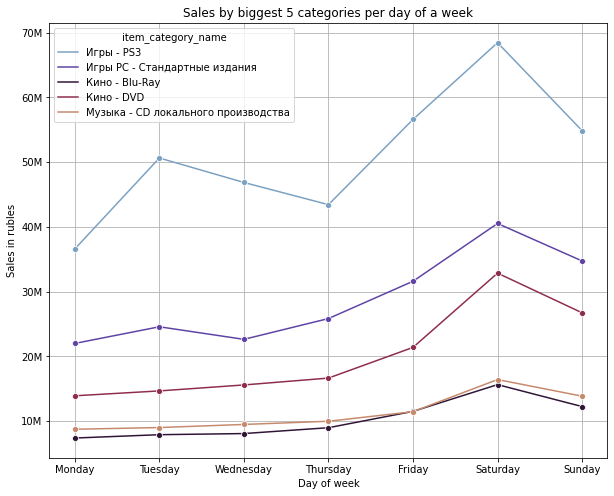

In [612]:
plt.figure(figsize=(10,8))
ax = sns.lineplot(
    data=agg_df,
    x='day_of_the_week',
    y='total_daily_sale',
    hue='item_category_name',
    palette='twilight',
    marker='o'
)
ax.yaxis.set_major_formatter(formatter)
plt.title('Sales by biggest 5 categories per day of a week')
plt.xlabel('Day of week')
plt.xticks(list(range(len(weekdays))), labels = weekdays)
plt.ylabel('Sales in rubles')
plt.grid()
plt.savefig(os.path.join(output_data_plots_path, 'top_5_categories_sales_per_each_day_of_the_week.png'))
plt.show()

Again, we are not surprised: our products have lots in common and thus the sales depict it pretty clearly. The sales in top 5 categories have the strongest effect on data we saw in previous graphs, so we anticipate the same pattern here.

However, we see that PS3 games are more dominant than PC games and XBox games. It's true since PS3 itself is more popular than Microsoft's console (even though I have XBox 360 at home :( )

### By a day of the month

In [613]:
agg_df = total_price_to_date_pd_df[
    ['item_category_name', 'day_of_the_month', 'total_daily_sale']
].groupby(['item_category_name', 'day_of_the_month']).sum()


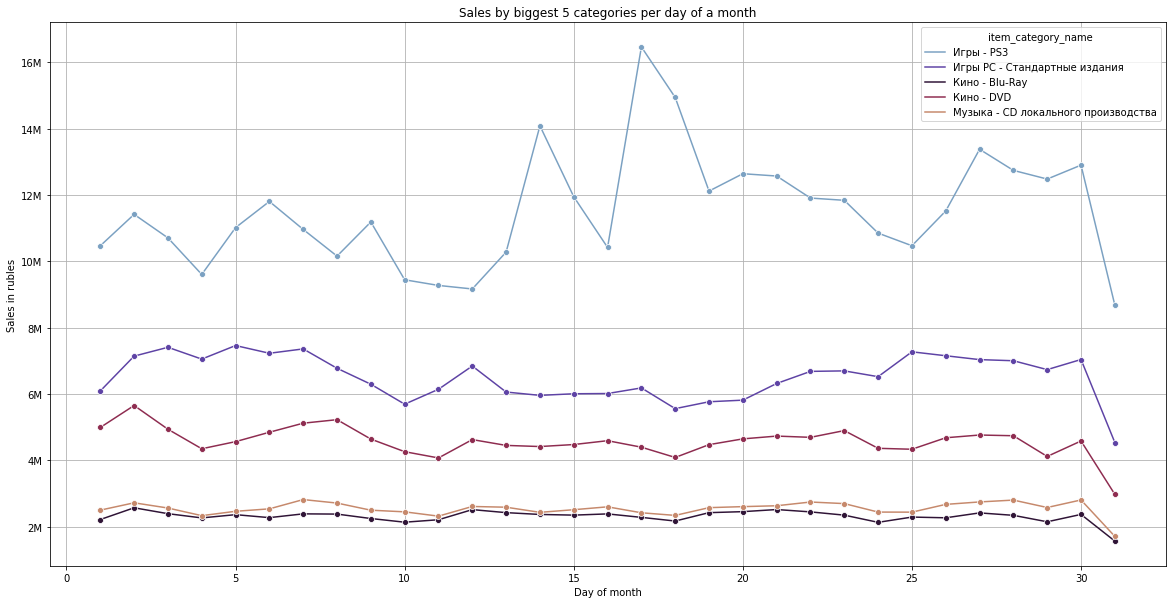

In [614]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(
    data=agg_df,
    x='day_of_the_month',
    y='total_daily_sale',
    hue='item_category_name',
    palette='twilight',
    marker='o'
)
ax.yaxis.set_major_formatter(formatter)
plt.title('Sales by biggest 5 categories per day of a month')
plt.xlabel('Day of month')
plt.ylabel('Sales in rubles')
plt.grid()
plt.savefig(os.path.join(output_data_plots_path, 'top_5_categories_sales_per_each_day_of_a_month.png'))
plt.show()

Here we see that PS3 games show some bizarre behaviour which is less correlated with other 4 categories. While other 4 categories have lots in common (if we considered these observations in terms of differentiating our dataset into distinct groups, our hypothesis will fail since DVDs and Music categories show almost identical trend, Blu-Ray disks have the same slope (their 1st derivative will be as well pretty similar to DVDs and music CDs) despite being a little bit higher (well, it's common knowledge that Blu-Rays are much more expensive than regular DVDs). PC games, on the other hand, show different behaviour than PS3 games. The reason for such deviation may lie in the fact that starting from the rise of PS3 and XBox, game industry has split into two almost separate and non-overlapping areas with PS3/XBox having more exlusive content and being more budget-friendly compared to PCs of comparative power.

### By a week of the year

In [615]:
agg_df = total_price_to_date_pd_df[
    ['item_category_name', 'week_of_the_year', 'total_daily_sale']
].groupby(['item_category_name', 'week_of_the_year']).sum()


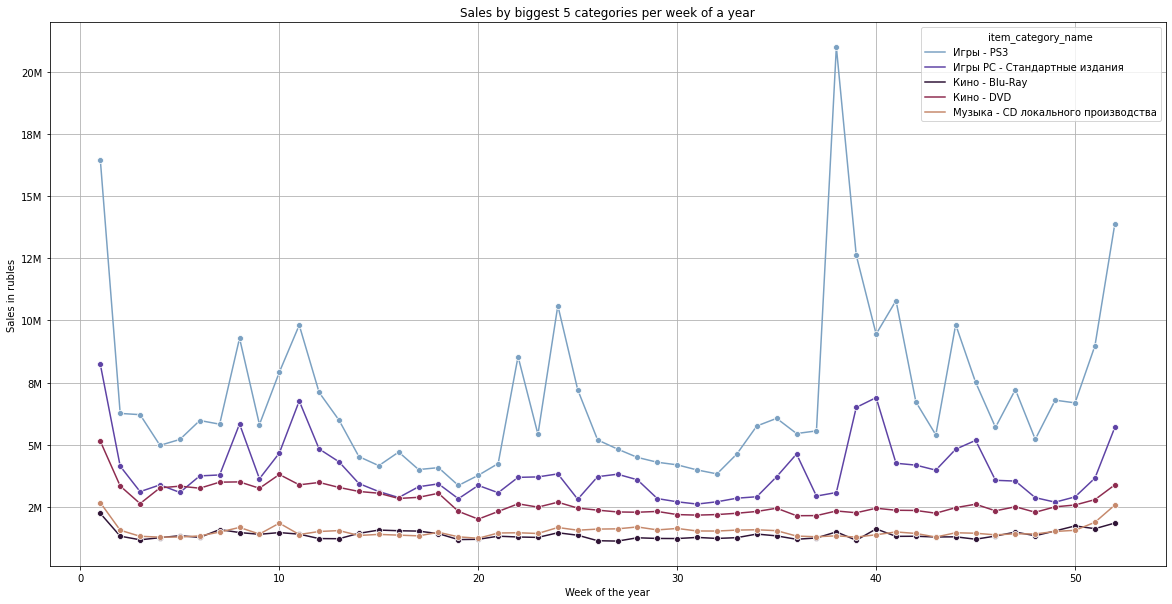

In [616]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(
    data=agg_df,
    x='week_of_the_year',
    y='total_daily_sale',
    hue='item_category_name',
    palette='twilight',
    marker='o'
)
ax.yaxis.set_major_formatter(formatter)
plt.title('Sales by biggest 5 categories per week of a year')
plt.xlabel('Week of the year')
plt.ylabel('Sales in rubles')
plt.grid()
plt.savefig(os.path.join(output_data_plots_path, 'top_5_categories_sales_per_each_day_of_a_year.png'))
plt.show()

Everything is pretty clear for DVDs, CDs and Blu-Rays. No need to discuss it.

What's more eye-catching are several peaks for both PS3 and PC games in the same time periods. The reason might be conveyed into some big releases (such as GTA V or Assassin's Creed) which in the time period we are interested in (2010s) had tendency to have parallel reseales on several platforms. This fact could cause such a correlation.

Another reason enforcing this behaviour might be that the target market of our show are kids playing games. Or in even broader context: people tend to play games rather than buying DVDs or CDs with music (these in Russia can be downloaded for free from Torrents), so there is no motivation in Russia in buying these things. That's why maybe this tendency contribute to the rise in sales in the beginning of autumn and also in the beginning of summer.

### By a month of the year

In [617]:
agg_df = total_price_to_date_pd_df[
    ['item_category_name', 'month_of_the_year', 'total_daily_sale']
].groupby(['item_category_name', 'month_of_the_year']).sum()


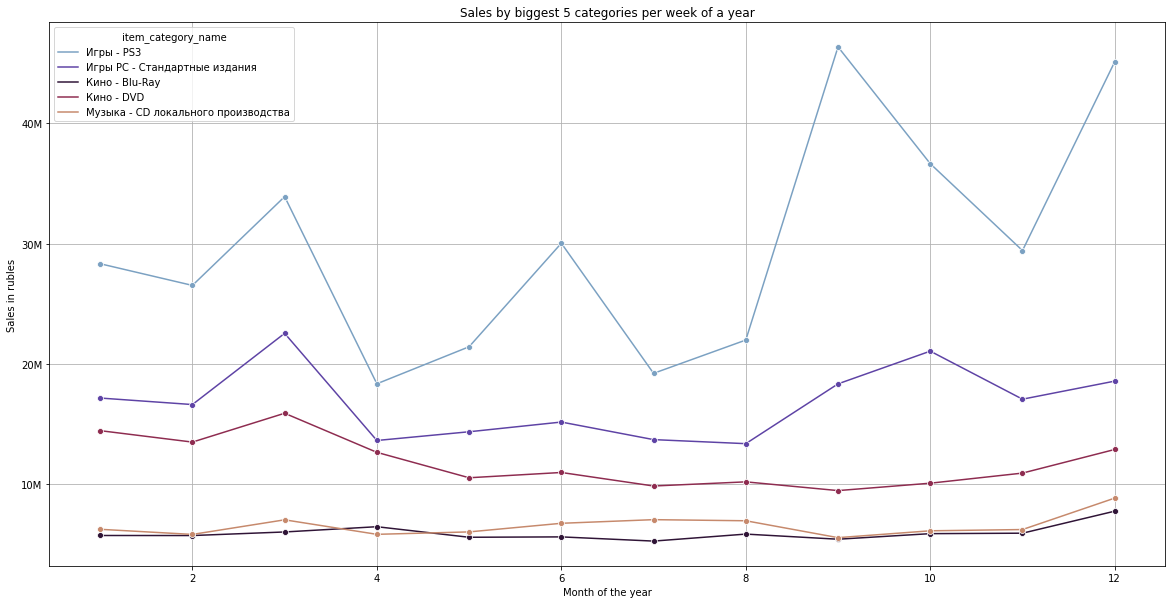

In [618]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(
    data=agg_df,
    x='month_of_the_year',
    y='total_daily_sale',
    hue='item_category_name',
    palette='twilight',
    marker='o'
)
ax.yaxis.set_major_formatter(formatter)
plt.title('Sales by biggest 5 categories per week of a year')
plt.xlabel('Month of the year')
plt.ylabel('Sales in rubles')
plt.grid()
plt.savefig(os.path.join(output_data_plots_path, 'top_5_categories_sales_per_each_week_of_the_year.png'))
plt.show()

In contrast to other graphs we have seen so far, this one shows that the sales of DVDs, CDs and Blu-Ray are pretty stable. We can then predict their future behaviour more confidently and make some better-grounded assumptions about this part of our goods. These categories can be also considered as stable in demand, so their XYZ classification might be X. 

We cannot claim that the need for PS3 games is stable. We see that PS3 games contribute more to our income, but the demand is more variable and we cannot expect the same number of sold items each month. So we are more prone to other factors that have higher influence on these goods (like new consoles, new games, holidays, popularity of these games and brands).

## Summary

We have conducted a profound study and analysed our data from lots of perspectives and angles. We have seen that by taking a look at the same data with respect to different time span, time range, categories, we obtain different insights which might help in defining the strategy of our business, our targets and goals.

There are lots of messages for marketing department that I've addressed throughout the analysis itself, so here I will be brief and hopefully clear in my thoughts.

First of all, we have several categories which are more predictable in terms of future demand and sales. They do not vary so much during the year and so the only thing we have to do is to keep an eye on considerable supply of these products throughout the next planned strategy time span. We have seen that there are such products (like Pink Floyd CDs, Deep Purple CDs, GTA SA game), which despite the fact that they are pretty old, they are still stable in terms of selling capabilities, that's why don't wish to run short of them.

We have also observed that we mostly benefit from selling games and from some event happening in game industry. So the message for the marketing team is to be in the picture of all the stuff happening in these spheres. The team has to be acquainted with the target market, be familiar of hot reseases and the upcoming events. Only by staying informed can we keep the sales high and hold attention of our customers. We have also to keep in mind that not only the games for PCs and consoles are being sold pretty well, but the consoles themselves, particularly on the eve of major holidays and events in social lives of our target market. That's why the team has to prepare some campaigns supporting this demand and at the same time take care of not running short of products we aim to sell to our customers.

There are also some peculiarities to take into consideration like targeting some ads towards our customers more agressively one week before the month ends or even some time before since it's the most profitable time of each month. 

As a result, the marketing team has lots of food for thought and will have by far less painful process of coming up with the ideas for future ads and marketing campaigns for supporting and rising our sales. 